# 第四章：模型训练

### Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 线性回归(Linear Regression)

线性回归模型预测：

线性回归模型: $$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n
$$

  .其中：n为特征数量，xi为第i个特征值，而θj表示第j个特征参数（包含偏置项（或者截距项）θ0以及特征权重θ（1-n））
  
也可以**向量化的表示**:$$
\hat{y} = h_\theta(\pmb{x}) = \pmb{\theta}\pmb{x}
$$
$$\pmb{\theta}\pmb{x}$$此时均为向量，也就是对应上式中的类似点积的形式

这就是线性回归模型

### 如何训练线性回归模型？
训练模型的过程本质上是设置模型参数直到模型最拟合训练集，而判断一个模型的性能好坏的标准，之前提到过RMSE评价指标，但实战中最小化均方差比RMSE更简单，而且效果是相同的 **回顾：https://blog.csdn.net/capecape/article/details/78623897**

构造一个线性的数据集是很简单的：

Saving figure generated_data_plot


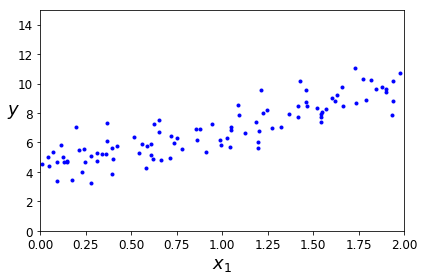

In [2]:
import numpy as np
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

这样我们就得到了一个数据集，现在我们用标准方程来计算$\hat{\theta}$

$
\hat{\theta} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}
$

numpy中特有的线性代数模块**np.linalg中inv()** 函数可以实现矩阵的求逆，然后用**dot()**方法来实现对矩阵内积的计算

矩阵内积：矩阵和矩阵的转置的积

In [3]:
X_b = np.c_[np.ones((100,1)),X]  #np.ones((a,b)):生成b个长度为a的一维向量（表现为a*b的数组）数组内容均为“1”
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
X_b.T.dot(X_b)

array([[100.        ,  94.03614868],
       [ 94.03614868, 123.47395265]])

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
# 对y进行预测
X_new = np.array([[0], [2], [3], [4]])
X_new_b = np.c_[np.ones((4, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.21509616],
       [ 9.75532293],
       [12.52543632],
       [15.2955497 ]])

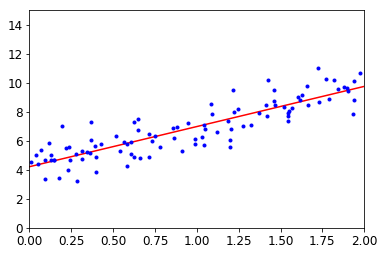

In [6]:
#绘制预测曲线
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

可以用sklearn更容易的实现线性回归

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict([[2],[6],[8],[9]])

array([[ 9.75532293],
       [20.83577648],
       [26.37600325],
       [29.14611664]])

LinearRegression类是基于**scipy.linalg.lstsq()**（最小二乘法）
我们来直接调用一下：

参数&返回值：https://blog.csdn.net/Yunshang12345/article/details/103608501

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

上述函数是通过矩阵的**伪逆**来实现：$\hat{\theta} = \pmb{X}^+y$

**pinv()** 是求矩阵的逆/伪逆的函数

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 梯度下降
梯度下降是一种通用的优化算法，能够为大范围问题找到最优解，其中心思想是**迭代的调整参数从而使成本函数最小化**

简单来说就是按照当前梯度决定方向进行迭代
https://blog.csdn.net/dpengwang/article/details/86028041
### 批量梯度下降流程：
首先使用一个随机的$\theta$值，然后逐步改进，每一步都尝试降低一点成本函数，知道算法收敛出一个最小值。梯度下降中有一个重要参数**步长**，这取决于**超参数学习率**
#### 学习率太高/太低？
学习率太低：直接达到“山谷”另一边，导致迭代甚至无法收敛；

学习率太高：有可能陷入**梯度下降陷阱**：找到了局部最小值而不是全局最小值

一个基本的梯度下降的迭代公式： $$\theta^{i+1}  = \theta^i-\eta\nabla_\theta {MSE}(\theta)$$

$$\nabla_\theta{MSE}(\theta)=\frac{2}{m}X^T(X\theta-y)$$

$\nabla_\theta {MSE}(\theta)$是梯度向量（不同维度的导数组成的向量）；$\eta$是学习速率

梯度向量中每个维度的偏导数计算公式：
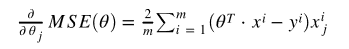

**一个快速实现**


In [11]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta # 完美的匹配线性回归的结果

array([[4.21509616],
       [2.77011339]])

Saving figure gradient_descent_plot


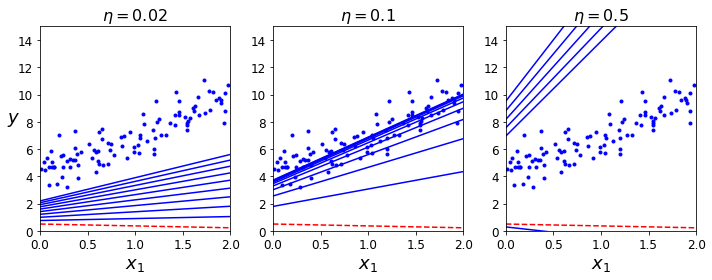

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

注意到，最右图学习率太高，找不到合适的解，左图的学习率太低，需要花更久的时间找到合适解

### 随机梯度下降
批量梯度下降的缺陷：需要用整个训练集来计算每一步的梯度，所以当训练集很大的时候，算法会特别慢，而**随机梯度下降法**正好是相反的，他每一步在训练集中随机选择**一个实例**，并且仅基于该单个实例来计算梯度，这样算法的速度变快很多
随机梯度下降更加不规则，不再是缓慢降低到最小值而是上上下下整体下降。

有一个缺点：永远定位不到最小值，于是可以采用逐步降低学习率的方法，开始步长较大，然后之间的降低步长，让算法尽量接近全局最小值，这种方法就是**模拟退火法**


Saving figure sgd_plot


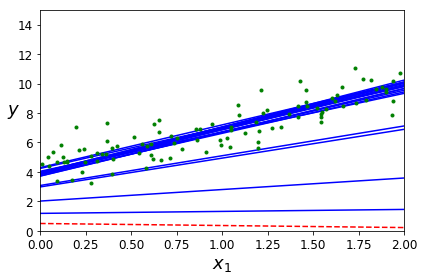

In [13]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        #print(eta)
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "g.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [14]:
theta

array([[4.21076011],
       [2.74856079]])

当然可以用sklearn内置的SGDRegressor

In [15]:

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

### 小批量梯度下降
不是根据完整的训练集或者仅基于一个实例来计算梯度，而是在随机的小型批量的实例下计算梯度

In [16]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

Saving figure gradient_descent_paths_plot


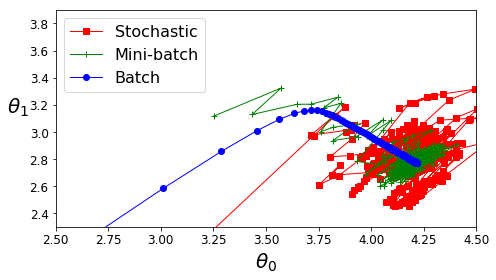

In [17]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=1, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=1, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## 多项式回归(Polynomial Regression)
可以用**线性模型来拟合非线性数据** 一个简单的方法是将每个特征的幂次添加为一个性特征没然后在拓展特征集上训练一个线性模型

首先基于一元二次方程式来生成一些非线性数据


In [18]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2+X+2+np.random.randn(m,1)

Saving figure quadratic_data_plot


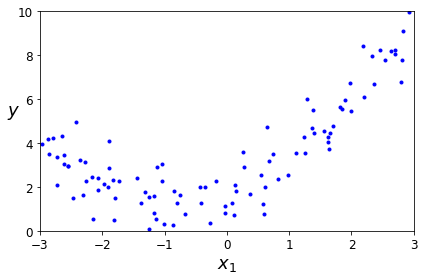

In [19]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [21]:
# X_poly现在包含X的原始特征以及该特征的平方。现在可以将LinearRegression模型拟合到此拓展训练数据中
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


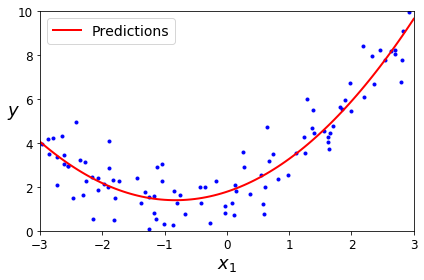

In [22]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Saving figure high_degree_polynomials_plot


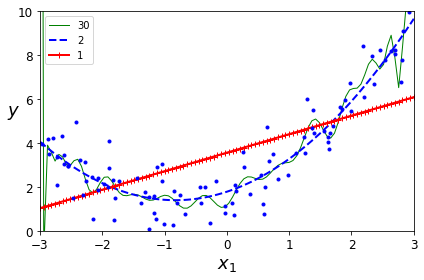

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
for style, width, degree in (("g-", 1, 30), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

### 如何确定模型的复杂性，判断是否过拟合或欠拟合？
交叉验证可以估计模型的泛化性能，泛化性能差则代表着过拟合现象的存在

还有一种直观的方法：直接观察学习曲线(生成逻辑：逐步增加训练集数量训练模型，看测试集上的表现逐步的变化)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)+1):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m]) # 就是y_train[:m]
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown


Saving figure underfitting_learning_curves_plot


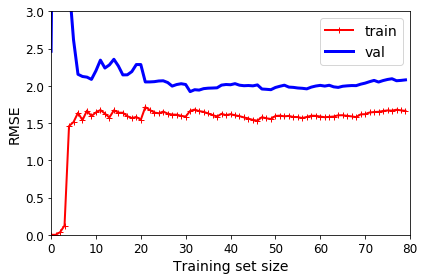

In [25]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                

In [26]:
# sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
# plot_learning_curves(sgd_reg, X, y)

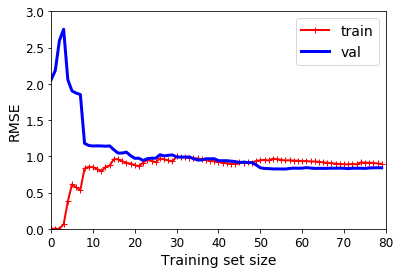

In [27]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
plt.axis([0, 80, 0, 3])           # not shown
plot_learning_curves(polynomial_regression, X, y)

## 正则化线性模型
减少过拟合的一个好方法是将模型进行正则化

对于线性模型正则化通常通过约束模型的权重来实现，接下来学习岭回归，Lasso回归和弹性网络，他们实现了三种限制权重的方法
### 岭回归(Tikhonov正则化)
是线性回归的正则化版本:将等于$\alpha \sum_{i=1}^n {\theta_i}^2$的正则化项加到成本函数中。这样能**破势学习算法不仅拟合数据，而且还使模型权重尽可能小，但注意仅仅在训练期间将正则化项添加到成本函数中**训练完后，要使用非正则化的性能度量来评估模型

训练过程中使用的成本函数和性能指标不同是常见的：除了正则化的情况外，不同的另一个原因是好的训练成本函数应该具有**对优化友好的导数**（使求梯度的过程变得更为快捷）eg.通常使用成本函数（如对数损失）来训练分类器，但评估时用精度/召回率的方式。

超参数$\alpha$控制要对模型进行正则化的程度，如果$\alpha$=0， 则岭回归就仅是线性回归，但如果$\alpha$非常大，则所有权重最终都非常接近于0，最终结果会是一条经过数据均值的平线。

岭回归的成本函数计算：
$$ J(\pmb{\theta})=MSE(\pmb{\theta})+\alpha\frac{1}{2}\sum_{i=2}^n{\theta_i}^2$$

偏置项$\theta_0$没有进行正则化。

在执行岭回归之前需要**缩放数据（如使用StandardScaler）**因为它对输入特征的缩放敏感，大多是正则化模型都需要如此

In [28]:
np.random.seed(42)
m = 100
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)
# np.linspace生成等间隔数据

In [29]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.73969402]])

In [30]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.75078107]])

Saving figure ridge_regression_plot


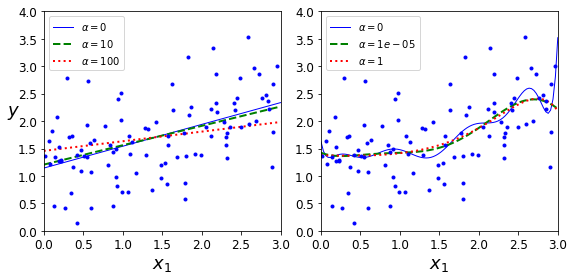

In [31]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        # zip函数：将两个可迭代的迭代器合并成一个迭代器,然后拆分，for each循环
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=10)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

以上是使用不同的alpha值对某些线性数据进行训练的几种模型：左侧使用的是普通岭模型，最终导致了**线性预测**；而右侧首先使用**PolynomialFeatures(degree = 10)拓展数据，然后使用StandardScaler对其进行缩放**，最后将岭模型用用于结果特征，**注意$\alpha$的增加会导致更平坦的预测，从而减少了模型的方差，但增加了偏差**

和线性回归一样，我们可以通过**计算闭合形式的方程或执行梯度下降**来执行岭回归

**闭式解的岭回归：**
$$\hat{\theta} = (X^TX+\alpha A)^{-1}X^Ty$$
其中A是(n+1)\*(n+1)的单位矩阵，除了**左上角单元格为0**

下面使用Sklearn和闭式解来执行岭回归

In [32]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.73969402]])

随机梯度下降：

In [33]:
sgd_reg = SGDRegressor(penalty = "l2") # 超参数penalty设置的是使用正则项的类型，而l2则表示希望SGD在成本函数中添加一个正则项，
#等于权重项链的L2范数的平方的一半，即岭回归
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.6947306])

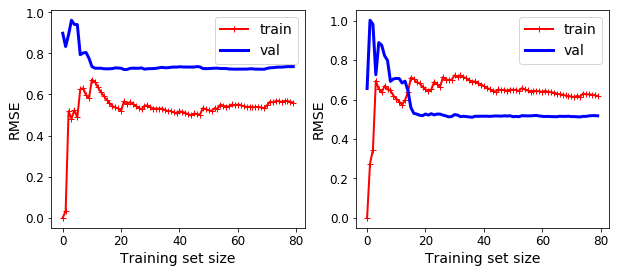

In [34]:
plt.figure(figsize=(10,4))
plt.axis([0, 80, 0, 3])           # not shown
plt.subplot(121);plot_learning_curves(ridge_reg, X, y)
plt.subplot(122);plot_learning_curves(ridge_reg, X, y)


### Lasso回归(Leaset Absolute Shrinkage and Selection Operator Regression)
### 最小绝对收缩和选择算子回归
和岭回归一样，lasso回归也是向成本函数里面增加一个正则项，但增加的是权重向量的$l_1$范数

成本函数：
$$
J(\theta)=MSE(\theta)+\alpha \sum^{n}_{i=1}|{\theta_i}|
$$

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e+01, tolerance: 4.833e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Saving figure lasso_regression_plot


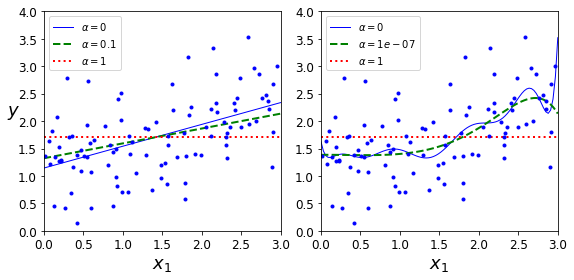

In [35]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

Lasso回归的一个重要特点：倾向于完全消除掉最不重要的特征的权重，即**将它们设为0**
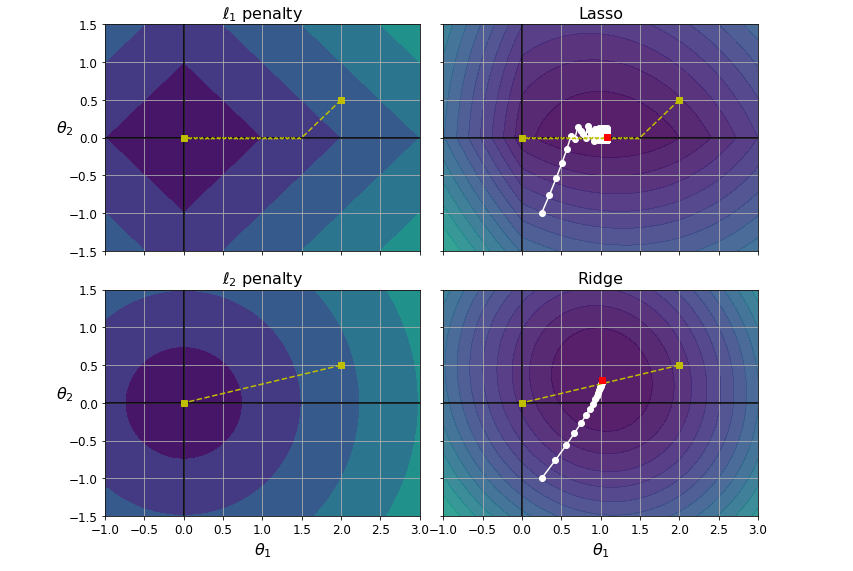
上图岭回归和Lasso回归的比较

比较其**l1损失和l2损失**下的表现，黄色的虚线是参数变化的过程，因为l1损失的梯度对于任何函数只有1或-1，所以表现出来的并不是一条直线而是在附近反弹。

右上角图片轮廓线表示的是Lasso的成本函数，白色小圆圈显示了梯度下降优化某些模型参数的路径，注意该路径如何快速到达$\theta_2=0$并在全局最优值的附近反弹（红色正方形表示），如果增加$\alpha$。则全局最优值将眼黄色虚线向左移动，如果减少$\alpha$，则全局最优值将向右移动

左下图中$l_2$损失随距离远点的距离而减少，因此，梯度下降自然会减慢，这有助于收敛。当增加$\alpha$时，最佳参数会越来越接近原点，但反弹从未被完全消除。为了避免反弹，要逐渐降低学习率（降低步长）

### 使用lasso类的小实例

In [36]:
from sklearn.linear_model import Lasso
# X = 3 * np.random.rand(m, 1)
# y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.72879488])

### 弹性网络（Elastic Net）
弹性网络结余岭回归和Lasso回归之间，相当于将二者混合，其中增加了一个混合比r
$$
J(\theta)=MSE(\theta)+r\alpha \sum^{n}_{i=1}|{\theta_i}|+\alpha\frac{1-r}{2}\sum_{i=2}^n{\theta_i}^2
$$
r=0是岭回归，r=1是Lasso回归

**如何选择？**
    通常来说，数据有正则化会比没有更可取一些，所以更倾向于Lasso或者弹性网络，因为它们会降低无用特征的权重，一般而言，弹性网络更优，因为当**特征数量超过训练实例量，有或者是几个特征强相关**的时候，Lasso回归表现会不稳定
    
### 弹性网络实例（sklearn.linear_model.ElasticNet）

In [37]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.73268344])

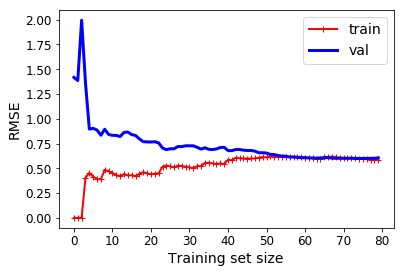

In [38]:
plot_learning_curves(polynomial_regression, X, y)

### 提前停止（Early Stopping）
在验证误差达到最小值时停止训练（RMSE最小值）
eg.批量梯度下降训练的复杂模型，经过一轮一轮的训练，算法不断学习，训练集的RMSE必然不断下降，但验证集在一段时间后开始停止下降，反而开始回升。说明模型发生了**过拟合**，在验证集的最小值的位置上需要**提前停止**，以得到最佳的模型

提前停止是一种**简单而有效的正则化技巧**，Geoffrey Hinton称其为“免费的午餐”

上述例子的演示代码：

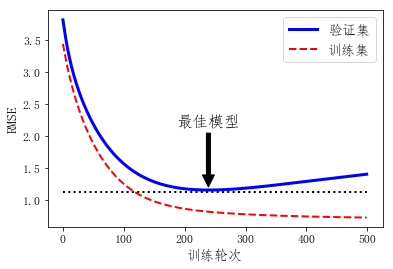

239

In [53]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['FangSong']
#产生数据集

np.random.seed(42)
m=100
X = 6*np.random.rand(m,1)-3
y = 2+X+0.5*X**2+np.random.randn(m,1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from copy import deepcopy
# 正则化处理
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

#寻找最优点，即提前停止的位置

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
# 获取val_errors最小项
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('最佳模型',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="验证集")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="训练集")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("训练轮次", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()
best_epoch


### **提前停止法的基本实现**

In [47]:
from copy import deepcopy
# 正则化处理
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
    # 找到了更好的模型，把最优模型深拷贝到best_model中

In [48]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))